# ADM - Homework 4

Group 24: Riccardo Agabiti, Adilet Karim, Aru Kakibay, Alessio Barboni 

### Import Libraries

In [7]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, random
import subprocess, re, itertools       
import scipy.io.wavfile  
import librosa, librosa.display
import IPython.display as ipd
from pathlib import Path, PurePath   
from tqdm.notebook import tqdm

### Define Functions Provided

In [8]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_picks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """[summary]

    Args:
        track (np.ndarray): A track.
        sr (int): Sampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure(figsize=(20,20))
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

def load_audio_picks(audio, duration, hop_size):
    """[summary]

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        duration (int): [description]
        hop_size (int): 

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)

    return track, sr, onset_env, peaks
    
    

## 1.1 Data Preparation

In [9]:
N_TRACKS = 1413 #Total number of tracks downloaded from Kaggle
HOP_SIZE = 512 #The number of samples in between successive frames, needed for applying the FFT

DURATION = 60 #Select the first n seconds of a track
THRESHOLD = 5 #Hyperparameter controlling the band width

In [10]:
data_folder = Path(r"C:\Users\alessio\Downloads\adm-hw4\mp3s-32k")
mp3_tracks = data_folder.glob("*\*\*.mp3")

#Converting mp3 format files into wav
#for track in tqdm(mp3_tracks, total=N_TRACKS):
#    convert_mp3_to_wav(str(track))

tracks = data_folder.glob("*\*\*.wav") #generator with all the tracks

First of all, let's extract the Author, Album and Title fields from the paths contained in variable "tracks" 

In [11]:
#First element of tracks
next(tracks)

WindowsPath('C:/Users/alessio/Downloads/adm-hw4/mp3s-32k/aerosmith/Aerosmith/01-Make_It.wav')

In [12]:
#data_folder = Path(r"C:\Users\alessio\Downloads\adm-hw4\mp3s-32k")
tracks = data_folder.glob("*\*\*.wav") #Reset the generator since one element has been removed

In [13]:
trackName=[] #Variable containing Author, Album and Title for each track 
for s in tracks:
    s=str(s)
    s=s[s.find("mp3s-32k")+len("mp3s-32k")+1:-4]
    s=re.sub("[\\\]"," ",s)
    s=s.split()
    s[-1] = s[-1][3:]
    trackName.append("Author: '{}', Album: '{}', Title: '{}'".format(re.sub("_"," ",s[0]),re.sub("_"," ",s[1]),re.sub("_"," ",s[2])))

In [14]:
#Extracted Fields from the first element
trackName[0]

"Author: 'aerosmith', Album: 'Aerosmith', Title: 'Make It'"

In [15]:
tracks = data_folder.glob("*\*\*.wav") #Reset the generator since all the elements have been removed

## 1.2 Fingerprint hashing

The idea now is to implement *Locality-Sensitive Hashing* (LSH) algorithm to find the title of the query tracks.

In this framework, we want to find unique features that are able to characterize a track, and differentiate it with respect to the others, possibibly noise-resistant since query tracks might be intended as in the case of Shazam as short recordings made with users smartphones (and thus full of background noise). We chose track's peaks, that are local maxima of the amplitude of a track. There are many different implementation, from using Librosa and finding the time at which a peak is detected on a 1D vector or defing a peak in 2D as a frequency-time pair and find them using e.g. image processing techniques. We chose the former implementation.

We will follow the implementation of https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/, building a MinHash Signature matrix, through permutation of our shingles that in this case are just the possible position in time of the peaks.

### Open Tracks in Python

Now we open all the tracks in Python using the *Librosa* library, each track will have 22050 data points per second (i.e. the sampling rate), but we do not need to store all these data points per track, since we are interested only in track's peaks. Hence for each track we can store a tuple of index of the track and list of peaks found.

In [11]:
ls=[] #list of index-listOfPeaks tuples
for idx, audio in tqdm(enumerate(tracks), total=N_TRACKS):
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    ls.append((idx, peaks)) 

In [15]:
#Initialize Shingles Matrix
#e.g. DURATION=1sec -> m: 43x1413 matrix, where 43 are the possible peak indexes in 1sec and 1413 the downloaded tracks  
peakListLen = DURATION*22050//HOP_SIZE #coinciding also with the number of overlapping windows of length 2048
m=np.zeros((peakListLen, N_TRACKS), dtype=int)
m

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [16]:
#Fill in the matrix iteratively with either 1 (if the shingle is present in the track) or 0 otherwise
for i in range(peakListLen):
        j=0
        while j<N_TRACKS:
            if i in ls[j][1]:
                m[i][j]=1
            j+=1

An important step for building the signature matrix's is to permutate the shingles and compute the MinHash step. We know that the number of permutations of n is equal to n factorial. With a duration of 1 second, there are 43 possible bins for the peaks. 43! is about 6.0415263e+52 that is already a very large number, let alone if we take a duration many more seconds, even minutes.

In this case it is not a computation or memory problem, since we could use generators, that are characterized by "lazy execution". Rather, given that number of permutation would be so huge (and considering that we want relatively a small portion of them for building the signature matrix) there would be minor changes from one permutation to the next, and given that the generator would provide one item at a time iteratively, without the possibility of shuffling the items that the generator is yielding, the risk of ending up with identical rows in the signature matrix becomes consistent. 

This problem is very specific to MinHashing, in which we select the index of the first 1 found in the Shingle Matrix, not considering at all the elements (1s or 0s) under the first 1 of the column. As shown below, using the itertools implementation of permutations, the elements at the end of the array would start changing order, but for the above cited reasons we are more interested on what happens at the start of the array, and yet, if only two rows out of the huge number of permutations change from one step two the other, the probability of having different in a significant way would be low.

In [17]:
import itertools
perm_iterator = itertools.permutations([1,2,3,4,5,6])
[x for x in perm_iterator][:6]

[(1, 2, 3, 4, 5, 6),
 (1, 2, 3, 4, 6, 5),
 (1, 2, 3, 5, 4, 6),
 (1, 2, 3, 5, 6, 4),
 (1, 2, 3, 6, 4, 5),
 (1, 2, 3, 6, 5, 4)]

In [36]:
# Permutation Generator Implementation
perm_iterator = itertools.permutations(m)
num_perm=5
signatureMatrix = []
for idx, item in enumerate(perm_iterator):   
    if idx==num_perm:
        break
    mm = np.transpose(np.array(item))
    sigLs = []
    for i in range(N_TRACKS):
        j=0
        while mm[i][j]!=1:
            if j==peakListLen-1:
                break
            j+=1
        sigLs.append(j)
    signatureMatrix.append(sigLs)

In [37]:
np.array(signatureMatrix).reshape(num_perm,N_TRACKS)

array([[ 23,  17,  15, ...,  14, 135,  55],
       [ 23,  17,  15, ...,  14, 135,  55],
       [ 23,  17,  15, ...,  14, 135,  55],
       [ 23,  17,  15, ...,  14, 135,  55],
       [ 23,  17,  15, ...,  14, 135,  55]])

As we can see above, the matrix has all the rows equal, since the permutated rows in the shingles matrix were the last ones, that most of the times do not have an effect on the position of the first 1 found in the column since after we have found the first 1 we stop iterating over that same column.

For this reason we would just random shuffle the list of shingles at each iteration, as an approximation, since repetitions would be rare in this scenario.

In [38]:
#Set a seed for reproducibility
import random
random.seed(42)

In [39]:
# Random Shuffling Implementation (Approximation)
shingles = list(range(peakListLen)) #since they coincide with the number of bins created by applying FFT
signatureMatrix = []
num_perm = 10000
for _ in tqdm(range(num_perm), total=num_perm):
    temp=[]
    random.shuffle(shingles) #the approximation of a permutation with very high n
    for i in range(ls[-1][0]+1): #i.e., range(N_TRACKS)
        j=0
        while shingles[j] not in ls[i][1]: #ls[i][1]=> list of peaks for i-th track
            if j==peakListLen-1: #we need ONLY the first non-zero entry of the column, we can break after finding it
                break
            j+=1
        temp.append(j) #elements that compose the rows of the signature matrix
    signatureMatrix.append(temp)

In [40]:
signatureMatrix=np.array(signatureMatrix) #cast the list of lists to array
signatureMatrix

array([[19, 56,  5, ..., 21,  8, 23],
       [ 1, 83, 14, ..., 16, 24,  0],
       [43,  0,  3, ..., 16, 11,  7],
       ...,
       [ 9, 14, 21, ..., 23, 38, 29],
       [40, 77, 12, ..., 11, 11,  8],
       [15, 11, 56, ..., 14,  7,  3]])

We can take the transpose of the signature matrix since for computing *bands* we want to operate by column, after that we can flatten it to make the band slicing easier.

In [41]:
perms_transp = np.transpose(np.array(signatureMatrix)) 
print(perms_transp)
perms_flat = perms_transp.flatten() #the flatten transposed signature matrix
print("\n",perms_flat)

[[19  1 43 ...  9 40 15]
 [56 83  0 ... 14 77 11]
 [ 5 14  3 ... 21 12 56]
 ...
 [21 16 16 ... 23 11 14]
 [ 8 24 11 ... 38 11  7]
 [23  0  7 ... 29  8  3]]

 [19  1 43 ... 29  8  3]


In [42]:
perms_transp.shape

(1413, 10000)

In [43]:
#Local Sensitive Hashing
num_bands = THRESHOLD
bands = []
c=0
for i in tqdm(range(0, len(perms_flat), num_bands), total=len(perms_flat)/num_bands):
    if i in list(range(num_perm,num_perm*1413+1,num_perm)):
        c+=1
    try:
        bands.append(([perms_flat[j] for j in range(i,num_bands+i)], c))
    except:
        pass #if something goes wrong with the indexes of the last elements we skip, since num_perm>>last few rows
             #whose number is not large enough to form a band

In [45]:
bands[:5]

[([19, 1, 43, 4, 2], 0),
 ([26, 12, 4, 28, 3], 0),
 ([39, 7, 17, 6, 17], 0),
 ([2, 6, 48, 7, 5], 0),
 ([17, 2, 36, 11, 31], 0)]

In [46]:
buckets = {}
for x in bands:
    x[0].sort()
    if str(x) not in buckets.keys():
        buckets[str(x[0])] = [] 
    buckets[str(x[0])].append(trackName[x[1]])

In [68]:
buckets

{'[1, 2, 4, 19, 43]': ["Author: 'queen', Album: 'News Of The World', Title: 'We Will Rock You'"],
 '[3, 4, 12, 26, 28]': ["Author: 'fleetwood mac', Album: 'Tusk', Title: 'I Know I m Not Wrong'"],
 '[6, 7, 17, 17, 39]': ["Author: 'aerosmith', Album: 'Aerosmith', Title: 'Make It'"],
 '[2, 5, 6, 7, 48]': ["Author: 'tori amos', Album: 'Scarlet s Walk', Title: 'Strange'"],
 '[2, 11, 17, 31, 36]': ["Author: 'aerosmith', Album: 'Aerosmith', Title: 'Make It'"],
 '[4, 6, 7, 20, 33]': ["Author: 'suzanne vega', Album: 'Songs in Red and Gray', Title: 'Songs in Red and Gray'"],
 '[13, 17, 24, 24, 28]': ["Author: 'aerosmith', Album: 'Aerosmith', Title: 'Make It'"],
 '[5, 7, 7, 14, 38]': ["Author: 'queen', Album: 'The Game', Title: 'Sail Away Sweet Sister'"],
 '[1, 9, 12, 58, 71]': ["Author: 'aerosmith', Album: 'Aerosmith', Title: 'Make It'"],
 '[1, 4, 6, 30, 41]': ["Author: 'green day', Album: 'Nimrod', Title: 'Redundant'"],
 '[1, 13, 26, 29, 43]': ["Author: 'aerosmith', Album: 'Aerosmith', Title: '

### QUERY

In [69]:
data_folder = Path(r"C:\Users\alessio\Downloads\adm-hw4\query")
tracksQ = data_folder.glob("*.wav")

In [70]:
lsQ=[]
for idx, audio in tqdm(enumerate(tracksQ), total=10):
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    lsQ.append((idx, peaks))

In [71]:
lsQ[0]

(0,
 array([  15,   34,   50,   67,   84,  100,  116,  132,  150,  167,  183,
         199,  215,  233,  249,  265,  281,  298,  315,  331,  347,  364,
         380,  396,  412,  430,  445,  462,  478,  546,  563,  579,  596,
         612,  629,  646,  663,  679,  696,  712,  729,  745,  762,  777,
         794,  809,  827,  843,  860,  876,  893,  909,  926,  942,  959,
         974,  991, 1007, 1024, 1041, 1056, 1072, 1090, 1106, 1123, 1139,
        1155, 1172, 1189, 1205, 1223, 1239, 1254, 1271, 1288, 1304, 1320,
        1336, 1369, 1385, 1401, 1426, 1451, 1467, 1483, 1500, 1516, 1533,
        1554, 1576, 1599, 1618, 1634, 1663, 1703, 1719, 1736, 1770, 1803,
        1837, 1854, 1870, 1888, 1904, 1922, 1938, 1971, 1989, 2005, 2039,
        2073, 2107, 2123, 2141, 2159, 2175, 2193, 2209, 2234, 2261, 2277,
        2295, 2311, 2328, 2345, 2379, 2395, 2412, 2447, 2480, 2496, 2513,
        2530, 2547, 2565, 2580], dtype=int64))

In [72]:
mQ=np.zeros((peakListLen, 10), dtype=int)

In [73]:
#Fill in the matrix
for i in range(peakListLen):
        j=0
        while j<10:
            if i in ls[j][1]:
                mQ[i][j]=1
            j+=1

In [75]:
# Random Shuffling Implementation (Approximation)
shinglesQ = list(range(peakListLen))
signatureMatrixQ = [] 
num_perm = 1000
for _ in tqdm(range(num_perm), total=num_perm):
    temp=[]
    random.shuffle(shinglesQ)
    for i in range(lsQ[-1][0]+1):
        j=0
        while shinglesQ[j] not in lsQ[i][1]:
            if j==peakListLen:
                break
            j+=1
        temp.append(j)
    signatureMatrixQ.append(temp)

In [76]:
signatureMatrixQ[:5]

[[11, 0, 8, 44, 4, 12, 29, 13, 37, 11],
 [39, 21, 19, 52, 6, 0, 0, 3, 6, 31],
 [9, 17, 19, 20, 24, 10, 24, 13, 1, 17],
 [4, 33, 2, 50, 1, 24, 78, 10, 16, 75],
 [5, 9, 3, 16, 1, 55, 22, 3, 11, 34]]

In [77]:
perms_transpQ = np.transpose(np.array(signatureMatrixQ))
print(perms_transpQ)
perms_flatQ = perms_transpQ.flatten()
print("\n",perms_flatQ)

[[11 39  9 ... 40 99 17]
 [ 0 21 17 ...  4 21  9]
 [ 8 19 19 ... 17  8  9]
 ...
 [13  3 13 ... 14 19  4]
 [37  6  1 ... 12 25 10]
 [11 31 17 ...  0 26 50]]

 [11 39  9 ...  0 26 50]


Now that we have built the signature matrix for the query, and created bands, we map them in the previously created buckets in order to find matches and ultimately the song title of the query tracks. 

In [78]:
output=[]
for i in range(10):
    j=0
    temp=[]
    while j<=10000:
        x=list(perms_transpQ[i,j:j+5])
        x.sort()
        if str(x) in buckets.keys():
            temp.append(buckets[str(x)][0])
        j+=5
    output.append((i,set(temp)))

In [79]:
output

[(0,
  {"Author: 'aerosmith', Album: 'Draw the Line', Title: 'Critical Mass'",
   "Author: 'beatles', Album: 'A Hard Day s Night', Title: 'A Hard Day s Night'",
   "Author: 'beatles', Album: 'Abbey Road', Title: 'Mean Mr Mustard'",
   "Author: 'creedence clearwater revival', Album: 'Pendulum', Title: 'Pagan Baby'",
   "Author: 'creedence clearwater revival', Album: 'Willy and the Poor Boys', Title: 'Fortunate son'",
   "Author: 'cure', Album: 'Kiss Me Kiss Me Kiss Me', Title: 'Like Cockatoos'",
   "Author: 'cure', Album: 'Wish', Title: 'Friday I m In Love'",
   "Author: 'dave matthews band', Album: 'Before These Crowded Streets', Title: 'Stay Wasting Time '",
   "Author: 'dave matthews band', Album: 'Busted Stuff', Title: 'You Never Know'",
   "Author: 'dave matthews band', Album: 'Everyday', Title: 'Sleep To Dream Her'",
   "Author: 'depeche mode', Album: 'A Broken Frame', Title: 'Monument'",
   "Author: 'depeche mode', Album: 'Music for the Masses', Title: 'Behind the wheel'",
   "Au

Using a bandwidth of 5 yields more than 100 matches per track, as we can see below. Thus in the next paragraph we will fine-tune the two hyperparameters, namely duration and bandwidth in order to get a meaningful number of matches.

In [83]:
len(output[0][1])

114

# Hyperparameter-Tuning

In the code above we have found too many matches per query track. Our goal is to get at most 1 match per track, and output its name. Hence, we are going to do some tune the duration, the number of bands and the number of permutations, keeping in mind also the computation time, that for an application like Shazam is as important as predicting tracks right.

Thus, we will try the fastest combination each time, whenever we find more than one match we are going to raise some of the above-mentioned parameters. In the specific, we are going to progressively lower the number of bands parameter, from 20 (that finds 0 matches with duration < 90 sec) to the first number at which some matches will be found, hoping that such number would be high, since at lower num_bands values, e.g. 2, there would be too many of matches for sure (it is an indicator for the robustness of the prediction basically). 

To improve this algorithm, we could take the number of num_bands at which it finds matches into account for computing a score that would approximate the accuracy of the prediction.

In [18]:
#Sort of GridSearch, wout CV lol

import random
random.seed(42)
DURATION = 30 

data_folder = Path(r"C:\Users\alessio\Downloads\adm-hw4\mp3s-32k")
mp3_tracks = data_folder.glob("*\*\*.mp3")
tracks = data_folder.glob("*\*\*.wav") 
ls=[]
for idx, audio in tqdm(enumerate(tracks), total=N_TRACKS):
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    ls.append((idx, peaks))
peakListLen = DURATION*22050//HOP_SIZE
m=np.zeros((peakListLen, N_TRACKS), dtype=int)
for i in range(peakListLen):
        j=0
        while j<(ls[-1][0]+1):
            if i in ls[j][1]:
                m[i][j]=1
            j+=1
shingles = list(range(peakListLen))
signatureMatrix = []
num_perm = 10000
signatureMatrix=[]
for _ in tqdm(range(num_perm), total=num_perm):
    temp=[]
    random.shuffle(shingles)
    for i in range(ls[-1][0]+1):
        j=0
        while shingles[j] not in ls[i][1]:
            if j==peakListLen-1:
                break
            j+=1
        temp.append(j)
    signatureMatrix.append(temp)
signatureMatrix=np.array(signatureMatrix)

perms_transp = np.transpose(np.array(signatureMatrix))
perms_flat = perms_transp.flatten()
#Ready for computing bands
data_folder = Path(r"C:\Users\alessio\Downloads\adm-hw4\query")
tracksQ = data_folder.glob("*.wav")

lsQ=[]
for idx, audio in tqdm(enumerate(tracksQ), total=10):
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    lsQ.append((idx, peaks))

mQ=np.zeros((peakListLen, 10), dtype=int)

for i in range(peakListLen):
        j=0
        while j<10:
            if i in ls[j][1]:
                mQ[i][j]=1
            j+=1

shinglesQ = list(range(peakListLen))
signatureMatrixQ = []
num_permQ = 10000
for _ in tqdm(range(num_perm), total=num_perm):
    temp=[]
    random.shuffle(shinglesQ)
    for i in range(lsQ[-1][0]+1):
        j=0
        while shinglesQ[j] not in lsQ[i][1]:
            if j==peakListLen:
                break
            j+=1
        temp.append(j)
    signatureMatrixQ.append(temp)

perms_transpQ = np.transpose(np.array(signatureMatrixQ))
perms_flatQ = perms_transpQ.flatten()
#Ready for computing bands pt.2

In [21]:
output=[]
for q in range(10):
    sent=True
    THRESHOLD = 20 
    num_bands = 20
    while sent:
        bands = []
        c=0
        for i in tqdm(range(0, len(perms_flat), num_bands), total=len(perms_flat)/num_bands):
            if i in list(range(num_perm,num_perm*1413+1,num_perm)):
                c+=1
            try:
                bands.append(([perms_flat[j] for j in range(i,num_bands+i)], c))
            except:
                pass 
        buckets = {}
        for x in bands:
            x[0].sort()
            if str(x) not in buckets.keys():
                buckets[str(x[0])] = [] 
            buckets[str(x[0])].append(trackName[x[1]])
        
        j=0
        temp=[]
        while j<=num_perm:
            x=list(perms_transpQ[q,j:j+THRESHOLD])
            x.sort()
            if str(x) in buckets.keys():
                temp.append(buckets[str(x)][0])
            j+=THRESHOLD
   
        if len(temp)>=1:
            sent=False
            output.append((q,set(temp)))
        print(THRESHOLD, temp)
        THRESHOLD-=1  
        num_bands-=1


20 []



19 []



18 []



17 []



16 []



15 []



14 []



13 []



12 []



11 ["Author: 'aerosmith', Album: 'Toys In The Attic', Title: 'No More No More'"]



20 []



19 []



18 []



17 []



16 []



15 []



14 []



13 []



12 []



11 []



10 ["Author: 'queen', Album: 'The Works', Title: 'I Want To Break Free'", "Author: 'steely dan', Album: 'Gaucho', Title: 'Gaucho'"]



20 []



19 []



18 []



17 []



16 []



15 []



14 []



13 []



12 []



11 ["Author: 'beatles', Album: 'A Hard Day s Night', Title: 'If I Fell'"]



20 []



19 []



18 []



17 []



16 []



15 []



14 []



13 []



12 []



11 []



10 []



9 []



8 ["Author: 'garth brooks', Album: 'No Fences The Limited Series ', Title: 'Same Old Story'"]



20 []



19 []



18 []



17 []



16 []



15 []



14 []



13 []



12 []



11 ["Author: 'beatles', Album: 'Magical Mystery Tour', Title: 'Penny Lane'"]



20 []



19 []



18 []



17 []



16 []



15 []



14 []



13 []



12 []



11 []



10 []



9 ["Author: 'beatles', Album: 'The White Album Disc 1', Title: 'Blackbird'", "Author: 'beatles', Album: 'Revolver', Title: 'I Want To Tell You'"]



20 []



19 []



18 []



17 []



16 []



15 []



14 []



13 []



12 []



11 []



10 []



9 ["Author: 'beatles', Album: 'Beatles For Sale', Title: 'Everybody s Trying To Be My Baby'", "Author: 'beatles', Album: 'A Hard Day s Night', Title: 'If I Fell'", "Author: 'beatles', Album: 'The White Album Disc 1', Title: 'Why Don t We Do It In The Road'", "Author: 'beatles', Album: 'Magical Mystery Tour', Title: 'Penny Lane'", "Author: 'beatles', Album: 'The White Album Disc 1', Title: 'Dear Prudence'"]



20 []



19 []



18 []



17 []



16 []



15 []



14 []



13 []



12 []



11 []



10 []



9 []



8 ["Author: 'aerosmith', Album: 'Pump', Title: 'F I N E '", "Author: 'cure', Album: 'Wish', Title: 'Wendy Time'", "Author: 'prince', Album: 'Purple Rain', Title: 'Baby I m a star'", "Author: 'dave matthews band', Album: 'Before These Crowded Streets', Title: 'Halloween'", "Author: 'dave matthews band', Album: 'Before These Crowded Streets', Title: 'Halloween'"]



20 []



19 []



18 []



17 []



16 []



15 []



14 []



13 []



12 []



11 ["Author: 'beatles', Album: 'The White Album Disc 1', Title: 'Back In The U S S R '"]



20 []



19 []



18 []



17 []



16 []



15 []



14 []



13 []



12 []



11 []



10 []



9 []



8 []



7 []



6 ["Author: 'cure', Album: 'Disintegration', Title: 'Prayers For Rain'", "Author: 'cure', Album: 'Kiss Me Kiss Me Kiss Me', Title: 'All I Want'", "Author: 'aerosmith', Album: 'Pump', Title: 'Hoodoo-Voodoo Medicine Man'", "Author: 'creedence clearwater revival', Album: 'Green River', Title: 'Commotion'", "Author: 'creedence clearwater revival', Album: 'Cosmo s Factory', Title: 'Before You Accuse Me'"]


In [22]:
print(output)

[(0, {"Author: 'aerosmith', Album: 'Toys In The Attic', Title: 'No More No More'"}), (1, {"Author: 'steely dan', Album: 'Gaucho', Title: 'Gaucho'", "Author: 'queen', Album: 'The Works', Title: 'I Want To Break Free'"}), (2, {"Author: 'beatles', Album: 'A Hard Day s Night', Title: 'If I Fell'"}), (3, {"Author: 'garth brooks', Album: 'No Fences The Limited Series ', Title: 'Same Old Story'"}), (4, {"Author: 'beatles', Album: 'Magical Mystery Tour', Title: 'Penny Lane'"}), (5, {"Author: 'beatles', Album: 'Revolver', Title: 'I Want To Tell You'", "Author: 'beatles', Album: 'The White Album Disc 1', Title: 'Blackbird'"}), (6, {"Author: 'beatles', Album: 'A Hard Day s Night', Title: 'If I Fell'", "Author: 'beatles', Album: 'The White Album Disc 1', Title: 'Dear Prudence'", "Author: 'beatles', Album: 'Magical Mystery Tour', Title: 'Penny Lane'", "Author: 'beatles', Album: 'The White Album Disc 1', Title: 'Why Don t We Do It In The Road'", "Author: 'beatles', Album: 'Beatles For Sale', Title: 

With this setting (duration: 30s, number of permutation: 10000), we have already found some unique matches:

(0, {"Author: 'aerosmith', Album: 'Toys In The Attic', Title: 'No More No More'"})

(2, {"Author: 'beatles', Album: 'A Hard Day s Night', Title: 'If I Fell'"})

(3, {"Author: 'garth brooks', Album: 'No Fences The Limited Series ', Title: 'Same Old Story'"})

(4, {"Author: 'beatles', Album: 'Magical Mystery Tour', Title: 'Penny Lane'"})

(8, {"Author: 'beatles', Album: 'The White Album Disc 1', Title: 'Back In The U S S R '"})

Still, 5 query tracks had more than 1 match and must be predicted again with larger parameters.
    

In [ ]:
#Sort of GridSearch, wout CV lol

import random
random.seed(42)

DURATION = 45 

data_folder = Path(r"C:\Users\alessio\Downloads\adm-hw4\mp3s-32k")
mp3_tracks = data_folder.glob("*\*\*.mp3")
tracks = data_folder.glob("*\*\*.wav") 

ls=[]
for idx, audio in tqdm(enumerate(tracks), total=N_TRACKS):
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    ls.append((idx, peaks))
peakListLen = DURATION*22050//HOP_SIZE
m=np.zeros((peakListLen, N_TRACKS), dtype=int)

for i in range(peakListLen):
        j=0
        while j<(ls[-1][0]+1):
            if i in ls[j][1]:
                m[i][j]=1
            j+=1

shingles = list(range(peakListLen))
signatureMatrix = []
num_perm = 20000
signatureMatrix=[]
for _ in tqdm(range(num_perm), total=num_perm):
    temp=[]
    random.shuffle(shingles)
    for i in range(ls[-1][0]+1):
        j=0
        while shingles[j] not in ls[i][1]:
            if j==peakListLen-1:
                break
            j+=1
        temp.append(j)
    signatureMatrix.append(temp)
signatureMatrix=np.array(signatureMatrix)

perms_transp = np.transpose(np.array(signatureMatrix))
perms_flat = perms_transp.flatten()
#Ready for computing bands
data_folder = Path(r"C:\Users\alessio\Downloads\adm-hw4\query")
tracksQ = data_folder.glob("*.wav")

lsQ=[]
for idx, audio in tqdm(enumerate(tracksQ), total=10):
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    lsQ.append((idx, peaks))

mQ=np.zeros((peakListLen, 10), dtype=int)

for i in range(peakListLen):
        j=0
        while j<10:
            if i in ls[j][1]:
                mQ[i][j]=1
            j+=1

shinglesQ = list(range(peakListLen))
signatureMatrixQ = []
num_permQ = 20000
for _ in tqdm(range(num_perm), total=num_perm):
    temp=[]
    random.shuffle(shinglesQ)
    for i in range(lsQ[-1][0]+1):
        j=0
        while shinglesQ[j] not in lsQ[i][1]:
            if j==peakListLen:
                break
            j+=1
        temp.append(j)
    signatureMatrixQ.append(temp)

perms_transpQ = np.transpose(np.array(signatureMatrixQ))
perms_flatQ = perms_transpQ.flatten()
#Ready for computing bands pt.2

In [26]:
output=[]
for q in [1,5,6,7,9]:
    sent=True
    THRESHOLD = 20 
    num_bands = 20
    while sent:
        bands = []
        c=0
        for i in tqdm(range(0, len(perms_flat), num_bands), total=len(perms_flat)/num_bands):
            if i in list(range(num_perm,num_perm*1413+1,num_perm)):
                c+=1
            try:
                bands.append(([perms_flat[j] for j in range(i,num_bands+i)], c))
            except:
                pass 
        buckets = {}
        for x in bands:
            x[0].sort()
            if str(x) not in buckets.keys():
                buckets[str(x[0])] = [] 
            buckets[str(x[0])].append(trackName[x[1]])
        
        j=0
        temp=[]
        while j<=num_perm:
            x=list(perms_transpQ[q,j:j+THRESHOLD])
            x.sort()
            if str(x) in buckets.keys():
                temp.append(buckets[str(x)][0])
            j+=THRESHOLD
   
        if len(temp)>=1:
            sent=False
            output.append((q,set(temp)))
        print(THRESHOLD, temp)
        THRESHOLD-=1  
        num_bands-=1


20 []



19 []



18 []



17 []



16 []



15 []



14 []



13 []



12 []



11 ["Author: 'beatles', Album: 'Abbey Road', Title: 'She Came In Through The Bathroom Window'"]



20 []



19 []



18 []



17 []



16 []



15 []



14 []



13 []



12 []



11 []



10 ["Author: 'metallica', Album: 'Load', Title: 'Cure'"]



20 []



19 []



18 []



17 []



16 []



15 []



14 []



13 []



12 []



11 []



10 ["Author: 'cure', Album: 'Disintegration', Title: 'Closedown'"]



20 []



19 []



18 []



17 []



16 []



15 []



14 []



13 []



12 []



11 []



10 []



9 ["Author: 'beatles', Album: 'Revolver', Title: 'Got To Get You Into My Life'", "Author: 'beatles', Album: 'A Hard Day s Night', Title: 'Any Time At All'"]



20 []



19 []



18 []



17 []



16 []



15 []



14 []



13 []



12 []



11 []



10 []



9 []



8 ["Author: 'green day', Album: 'Nimrod', Title: 'Redundant'", "Author: 'steely dan', Album: 'Aja', Title: 'Peg'"]


In [27]:
output

[(1,
  {"Author: 'beatles', Album: 'Abbey Road', Title: 'She Came In Through The Bathroom Window'"}),
 (5, {"Author: 'metallica', Album: 'Load', Title: 'Cure'"}),
 (6, {"Author: 'cure', Album: 'Disintegration', Title: 'Closedown'"}),
 (7,
  {"Author: 'beatles', Album: 'A Hard Day s Night', Title: 'Any Time At All'",
   "Author: 'beatles', Album: 'Revolver', Title: 'Got To Get You Into My Life'"}),
 (9,
  {"Author: 'green day', Album: 'Nimrod', Title: 'Redundant'",
   "Author: 'steely dan', Album: 'Aja', Title: 'Peg'"})]

With this setting (duration: 45s, number of permutation: 20000), we have found:

(1, {"Author: 'beatles', Album: 'Abbey Road', Title: 'She Came In Through The Bathroom Window'"}

Other 4 to go...    

In [16]:
#Sort of GridSearch, wout CV lol

import random
random.seed(42)

DURATION = 60

data_folder = Path(r"C:\Users\alessio\Downloads\adm-hw4\mp3s-32k")
mp3_tracks = data_folder.glob("*\*\*.mp3")
tracks = data_folder.glob("*\*\*.wav") 

ls=[]
for idx, audio in tqdm(enumerate(tracks), total=N_TRACKS):
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    ls.append((idx, peaks))
peakListLen = DURATION*22050//HOP_SIZE
m=np.zeros((peakListLen, N_TRACKS), dtype=int)

for i in range(peakListLen):
        j=0
        while j<(ls[-1][0]+1):
            if i in ls[j][1]:
                m[i][j]=1
            j+=1

shingles = list(range(peakListLen))
signatureMatrix = []
num_perm = 20000
signatureMatrix=[]
for _ in tqdm(range(num_perm), total=num_perm):
    temp=[]
    random.shuffle(shingles)
    for i in range(ls[-1][0]+1):
        j=0
        while shingles[j] not in ls[i][1]:
            if j==peakListLen-1:
                break
            j+=1
        temp.append(j)
    signatureMatrix.append(temp)
signatureMatrix=np.array(signatureMatrix)

perms_transp = np.transpose(np.array(signatureMatrix))
perms_flat = perms_transp.flatten()
#Ready for computing bands
data_folder = Path(r"C:\Users\alessio\Downloads\adm-hw4\query")
tracksQ = data_folder.glob("*.wav")

lsQ=[]
for idx, audio in tqdm(enumerate(tracksQ), total=10):
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    lsQ.append((idx, peaks))

mQ=np.zeros((peakListLen, 10), dtype=int)

for i in range(peakListLen):
        j=0
        while j<10:
            if i in ls[j][1]:
                mQ[i][j]=1
            j+=1

shinglesQ = list(range(peakListLen))
signatureMatrixQ = []
num_permQ = 20000
for _ in tqdm(range(num_perm), total=num_perm):
    temp=[]
    random.shuffle(shinglesQ)
    for i in range(lsQ[-1][0]+1):
        j=0
        while shinglesQ[j] not in lsQ[i][1]:
            if j==peakListLen:
                break
            j+=1
        temp.append(j)
    signatureMatrixQ.append(temp)

perms_transpQ = np.transpose(np.array(signatureMatrixQ))
perms_flatQ = perms_transpQ.flatten()
#Ready for computing bands pt.2

  0%|          | 0/1413 [00:00<?, ?it/s]

In [19]:
output=[]
for q in [7,9]:
    sent=True
    THRESHOLD = 17 
    num_bands = 17 
    while sent:
        bands = []
        c=0
        for i in tqdm(range(0, len(perms_flat), num_bands), total=len(perms_flat)/num_bands):
            if i in list(range(num_perm,num_perm*1413+1,num_perm)):
                c+=1
            try:
                bands.append(([perms_flat[j] for j in range(i,num_bands+i)], c))
            except:
                pass 
        buckets = {}
        for x in bands:
            x[0].sort()
            if str(x) not in buckets.keys():
                buckets[str(x[0])] = [] 
            buckets[str(x[0])].append(trackName[x[1]])
        
        j=0
        temp=[]
        while j<=num_perm:
            x=list(perms_transpQ[q,j:j+THRESHOLD])
            x.sort()
            if str(x) in buckets.keys():
                temp.append(buckets[str(x)][0])
            j+=THRESHOLD
   
        if len(temp)>=1: 
            sent=False
            output.append((q,set(temp)))
        print(THRESHOLD, temp)
        THRESHOLD-=1  
        num_bands-=1

  0%|          | 0/1662352.9411764706 [00:00<?, ?it/s]

17 []


  0%|          | 0/1766250.0 [00:00<?, ?it/s]

16 []


  0%|          | 0/1884000.0 [00:00<?, ?it/s]

15 []


  0%|          | 0/2018571.4285714286 [00:00<?, ?it/s]

14 []


  0%|          | 0/2173846.153846154 [00:00<?, ?it/s]

13 []


  0%|          | 0/2355000.0 [00:00<?, ?it/s]

12 []


  0%|          | 0/2569090.909090909 [00:00<?, ?it/s]

11 []


  0%|          | 0/2826000.0 [00:00<?, ?it/s]

10 ["Author: 'beatles', Album: 'Beatles For Sale', Title: 'Baby s In Black'"]


  0%|          | 0/1662352.9411764706 [00:00<?, ?it/s]

17 []


  0%|          | 0/1766250.0 [00:00<?, ?it/s]

16 []


  0%|          | 0/1884000.0 [00:00<?, ?it/s]

15 []


  0%|          | 0/2018571.4285714286 [00:00<?, ?it/s]

14 []


  0%|          | 0/2173846.153846154 [00:00<?, ?it/s]

13 []


  0%|          | 0/2355000.0 [00:00<?, ?it/s]

12 []


  0%|          | 0/2569090.909090909 [00:00<?, ?it/s]

11 []


  0%|          | 0/2826000.0 [00:00<?, ?it/s]

10 []


  0%|          | 0/3140000.0 [00:00<?, ?it/s]

9 ["Author: 'beatles', Album: 'Beatles For Sale', Title: 'What You re Doing'", "Author: 'beatles', Album: 'Magical Mystery Tour', Title: 'Magical Mystery Tour'"]


In [20]:
output

[(7,
  {"Author: 'beatles', Album: 'Beatles For Sale', Title: 'Baby s In Black'"}),
 (9,
  {"Author: 'beatles', Album: 'Beatles For Sale', Title: 'What You re Doing'",
   "Author: 'beatles', Album: 'Magical Mystery Tour', Title: 'Magical Mystery Tour'"})]

With this setting (duration: 60s, number of permutation: 20000), we have found:

(7, {"Author: 'beatles', Album: 'Beatles For Sale', Title: 'Baby s In Black'"})

The last one to go...    

In [21]:
#Sort of GridSearch, wout CV lol

import random
random.seed(42)

DURATION = 90

data_folder = Path(r"C:\Users\alessio\Downloads\adm-hw4\mp3s-32k")
mp3_tracks = data_folder.glob("*\*\*.mp3")
tracks = data_folder.glob("*\*\*.wav") 

ls=[]
for idx, audio in tqdm(enumerate(tracks), total=N_TRACKS):
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    ls.append((idx, peaks))
peakListLen = DURATION*22050//HOP_SIZE
m=np.zeros((peakListLen, N_TRACKS), dtype=int)

for i in range(peakListLen):
        j=0
        while j<(ls[-1][0]+1):
            if i in ls[j][1]:
                m[i][j]=1
            j+=1

shingles = list(range(peakListLen))
signatureMatrix = []
num_perm = 50000
signatureMatrix=[]
for _ in tqdm(range(num_perm), total=num_perm):
    temp=[]
    random.shuffle(shingles)
    for i in range(ls[-1][0]+1):
        j=0
        while shingles[j] not in ls[i][1]:
            if j==peakListLen-1:
                break
            j+=1
        temp.append(j)
    signatureMatrix.append(temp)
signatureMatrix=np.array(signatureMatrix)

perms_transp = np.transpose(np.array(signatureMatrix))
perms_flat = perms_transp.flatten()
#Ready for computing bands
data_folder = Path(r"C:\Users\alessio\Downloads\adm-hw4\query")
tracksQ = data_folder.glob("*.wav")

lsQ=[]
for idx, audio in tqdm(enumerate(tracksQ), total=10):
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    lsQ.append((idx, peaks))

mQ=np.zeros((peakListLen, 10), dtype=int)

for i in range(peakListLen):
        j=0
        while j<10:
            if i in ls[j][1]:
                mQ[i][j]=1
            j+=1

shinglesQ = list(range(peakListLen))
signatureMatrixQ = []
num_permQ = 50000
for _ in tqdm(range(num_perm), total=num_perm):
    temp=[]
    random.shuffle(shinglesQ)
    for i in range(lsQ[-1][0]+1):
        j=0
        while shinglesQ[j] not in lsQ[i][1]:
            if j==peakListLen:
                break
            j+=1
        temp.append(j)
    signatureMatrixQ.append(temp)

perms_transpQ = np.transpose(np.array(signatureMatrixQ))
perms_flatQ = perms_transpQ.flatten()
#Ready for computing bands pt.2

  0%|          | 0/1413 [00:00<?, ?it/s]

In [24]:
output=[]
for q in [9]:
    sent=True
    THRESHOLD = 17 
    num_bands = 17 
    while sent:
        bands = []
        c=0
        for i in tqdm(range(0, len(perms_flat), num_bands), total=len(perms_flat)/num_bands):
            if i in list(range(num_perm,num_perm*1413+1,num_perm)):
                c+=1
            try:
                bands.append(([perms_flat[j] for j in range(i,num_bands+i)], c))
            except:
                pass 
        buckets = {}
        for x in bands:
            x[0].sort()
            if str(x) not in buckets.keys():
                buckets[str(x[0])] = [] 
            buckets[str(x[0])].append(trackName[x[1]])
        
        j=0
        temp=[]
        while j<=num_perm:
            x=list(perms_transpQ[q,j:j+THRESHOLD])
            x.sort()
            if str(x) in buckets.keys():
                temp.append(buckets[str(x)][0])
            j+=THRESHOLD
   
        if len(temp)>=1:
            sent=False
            output.append((q,set(temp)))
        print(THRESHOLD, temp)
        THRESHOLD-=1  
        num_bands-=1

  0%|          | 0/4155882.3529411764 [00:00<?, ?it/s]

17 []


  0%|          | 0/4415625.0 [00:00<?, ?it/s]

16 []


  0%|          | 0/4710000.0 [00:00<?, ?it/s]

15 []


  0%|          | 0/5046428.571428572 [00:00<?, ?it/s]

14 []


  0%|          | 0/5434615.384615385 [00:00<?, ?it/s]

13 []


  0%|          | 0/5887500.0 [00:00<?, ?it/s]

12 ["Author: 'dave matthews band', Album: 'Crash', Title: 'Too Much'"]


With this setting (duration: 90s, number of permutation: 50000), we have found:

{12, "Author: 'dave matthews band', Album: 'Crash', Title: 'Too Much'"}

Hence, in the end, what we have found is the following:

(0, {"Author: 'aerosmith', Album: 'Toys In The Attic', Title: 'No More No More'"});

(1,{"Author: 'beatles', Album: 'Abbey Road', Title: 'She Came In Through The Bathroom Window'"});

(2, {"Author: 'beatles', Album: 'A Hard Day s Night', Title: 'If I Fell'"});

(3, {"Author: 'garth brooks', Album: 'No Fences The Limited Series ', Title: 'Same Old Story'"});

(4, {"Author: 'beatles', Album: 'Magical Mystery Tour', Title: 'Penny Lane'"});

(5, {"Author: 'metallica', Album: 'Load', Title: 'Cure'"});

(6, {"Author: 'cure', Album: 'Disintegration', Title: 'Closedown'"});

(7, {"Author: 'beatles', Album: 'Beatles For Sale', Title: 'Baby s In Black'"});

(8, {"Author: 'beatles', Album: 'The White Album Disc 1', Title: 'Back In The U S S R '"})

(9, {"Author: 'dave matthews band', Album: 'Crash', Title: 'Too Much'"});

We claim that everything could be solved by using duration: 90s, number of permutation: 50000, and numb_bands decreasing from 20 but that would require, with our algorithm and our machine, hours to say the least, thus it is not in line with the primary goal of an application like shazam.  

# 2

In [356]:
import pandas as pd, numpy as np

In [357]:
df1 = pd.read_csv('echonest.csv')
df2 = pd.read_csv('features.csv')
df3 = pd.read_csv('tracks.csv')

The primary key used for merging is the set of column in common in all three datasets.

In [358]:
[x for x in df1.columns if x in df2.columns] #common columns between first and second datasets

['track_id']

Just by looking at the first two datasets we find out that this key is 'track_id'.

In [359]:
len(list(df1.columns)+list(df2.columns)+list(df3.columns))-2
#in this way we count "track_id" one time, hence we remove 2

820

In [360]:
#Merge DataFrames
df=df1.merge(df2.merge(df3))
len(df.columns)

820

In [361]:
df.shape

(13129, 820)

### 2.1 Preprocessing

In [7]:
df.isnull().sum()

track_id                               0
audio_features_acousticness            0
audio_features_danceability            0
audio_features_energy                  0
audio_features_instrumentalness        0
                                   ...  
track_lyricist                     13055
track_number                           0
track_publisher                    12977
track_tags                             0
track_title                            1
Length: 820, dtype: int64

In [362]:
threshold=0.25 #amount of NaNs that makes us drop that specific column
df.drop(columns=[x for x in df.columns if df[x].isnull().sum()/len(df.track_id) >=threshold], inplace=True)
print("{} columns have been dropped".format(820-len(list(df.columns))))

30 columns have been dropped


Some categorical column have NaN correspondences, e.g. an empty list for "track_tags".

In [9]:
len(list(df.track_tags[df.track_tags!="[]"])) #below the 0.25 threshold

2062

After dropping the columns with way to many missing values let's deal with the missing values of the remaining columns. For numerical variables we may decide to substitute the mean or the median, instead of dropping the row as a whole, while for categorical variables we will just drop it. 

In [363]:
#Numerical Variables Handling
print(df.select_dtypes(include="number").shape)
for col in df.select_dtypes(include="number").columns:
    if  df[col].isnull().sum()!=0:
        df[col].fillna(df[col].describe()["50%"]) #substitute the median

(13129, 771)


Now that we have dealt with numerical, we can just drop all remaining NaN using pd.dropna():

In [364]:
#Categorical Variables Handling
print(df.select_dtypes(include="object").shape)
df.dropna(inplace=True)
print(df.select_dtypes(include="object").isnull().sum())

(13129, 19)
metadata_artist_name    0
metadata_release        0
album_date_created      0
album_information       0
album_tags              0
album_title             0
album_type              0
artist_date_created     0
artist_name             0
artist_tags             0
artist_website          0
set_split               0
set_subset              0
track_date_created      0
track_genres            0
track_genres_all        0
track_license           0
track_tags              0
track_title             0
dtype: int64


In [365]:
df.reset_index(inplace=True)
df.drop(columns=["index"], inplace=True)

### Features Scaling

To apply Principal Component Analysis (and later for KMeans too), we need to scale our numerical features first. We chose to use MinMax Scaling

In [366]:
dfNum=df.select_dtypes(include="number")
dfNumStand = (dfNum - dfNum.min())/(dfNum.max()- dfNum.min())
dfNumStand

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,social_features_artist_discovery,...,artist_comments,artist_favorites,artist_id,track_bit_rate,track_comments,track_duration,track_favorites,track_interest,track_listens,track_number
0,0.000000,0.418434,0.680869,0.634544,0.010649,0.162347,0.145459,0.642706,0.576663,0.582495,...,0.0,0.009346,0.000000,0.794728,0.0,0.048489,0.001350,0.001395,0.002334,0.014085
1,0.000008,0.375988,0.520349,0.817554,0.001855,0.085559,0.466679,0.479206,0.269236,0.582495,...,0.0,0.009346,0.000000,0.794728,0.0,0.071405,0.000675,0.000427,0.000900,0.018779
2,0.000024,0.043750,0.756819,0.701547,0.000698,0.371523,0.108598,0.367184,0.621664,0.582495,...,0.0,0.009346,0.000000,0.794728,0.0,0.061109,0.004049,0.000568,0.002073,0.028169
3,0.001058,0.454126,0.503556,0.560467,0.019481,0.075594,0.534320,0.426055,0.894080,0.582495,...,0.0,0.009346,0.000000,0.794728,0.0,0.061441,0.002024,0.000323,0.001690,0.023474
4,0.001098,0.106998,0.228491,0.607130,0.836747,0.211598,0.008756,0.772947,0.160260,0.582395,...,0.0,0.011423,0.002547,0.397366,0.0,0.091000,0.002024,0.000194,0.001025,0.009390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8488,0.999912,0.027478,0.542267,0.746357,0.533692,0.253402,0.017498,0.483810,0.145135,0.614506,...,0.0,0.013499,0.299779,0.993409,0.0,0.089007,0.000000,0.000370,0.001671,0.009390
8489,0.999936,0.056555,0.660153,0.692825,0.253777,0.242401,0.114166,0.345134,0.446676,0.614506,...,0.0,0.013499,0.299779,0.993409,0.0,0.080704,0.000000,0.000412,0.002005,0.023474
8490,0.999976,0.020235,0.531878,0.861276,0.651338,0.511113,0.056382,0.647019,0.369777,0.614506,...,0.0,0.013499,0.299779,0.993409,0.0,0.110262,0.000000,0.000964,0.004495,0.046948
8491,0.999992,0.213091,0.698163,0.801827,0.427477,0.219866,0.038364,0.449952,0.418958,0.463349,...,0.0,0.012461,0.998895,0.993409,0.0,0.076719,0.001350,0.000823,0.004184,0.056338


Before applying PCA, we want to take out features that are important to us, since the result of such procedure would be a composition of variables, and no original variable would be preserved. 

Hence we have decided to remove all the variables that we could more easily understand: 'track_id', 'album_comments', 'album_favorites', 'album_id', 'album_listens', 'album_tracks', 'artist_comments', 'artist_favorites', 'artist_id', 'track_comments', 'track_duration', 'track_favorites', 'track_interest', 'track_listens', 'track_number'.

In [367]:
dfPca = dfNumStand.drop(columns=['track_id', 'album_comments', 'album_favorites', 'album_id', 'album_listens', 'album_tracks', 'artist_comments', 'artist_favorites', 'artist_id', 'track_comments', 'track_duration', 'track_favorites', 'track_interest', 'track_listens', 'track_number'])
dfPca

,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,social_features_artist_discovery,social_features_artist_familiarity,...,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01,track_bit_rate
0,0.418434,0.680869,0.634544,0.010649,0.162347,0.145459,0.642706,0.576663,0.582495,0.471984,...,0.073597,0.066612,0.006101,0.430484,0.168916,0.144985,0.000000,0.126931,0.262313,0.794728
1,0.375988,0.520349,0.817554,0.001855,0.085559,0.466679,0.479206,0.269236,0.582495,0.471984,...,0.102226,0.141205,0.003634,0.437693,0.166745,0.130089,0.000000,0.114975,0.297536,0.794728
2,0.043750,0.756819,0.701547,0.000698,0.371523,0.108598,0.367184,0.621664,0.582495,0.471984,...,0.080300,0.101706,0.006983,0.341401,0.101759,0.084409,0.000000,0.130245,0.188188,0.794728
3,0.454126,0.503556,0.560467,0.019481,0.075594,0.534320,0.426055,0.894080,0.582495,0.471984,...,0.132650,0.115757,0.005237,0.388260,0.125006,0.103277,0.000000,0.117839,0.231813,0.794728
4,0.106998,0.228491,0.607130,0.836747,0.211598,0.008756,0.772947,0.160260,0.582395,0.403694,...,0.148590,0.190896,0.002232,0.221421,0.138205,0.136048,0.013072,0.084614,0.121854,0.397366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8488,0.027478,0.542267,0.746357,0.533692,0.253402,0.017498,0.483810,0.145135,0.614506,0.445045,...,0.247851,0.246797,0.007183,0.453141,0.126728,0.114201,0.013072,0.121905,0.192623,0.993409
8489,0.056555,0.660153,0.692825,0.253777,0.242401,0.114166,0.345134,0.446676,0.614506,0.445045,...,0.238918,0.171137,0.007574,0.395984,0.102452,0.077458,0.000000,0.132877,0.209874,0.993409
8490,0.020235,0.531878,0.861276,0.651338,0.511113,0.056382,0.647019,0.369777,0.614506,0.445045,...,0.174013,0.185153,0.003623,0.277034,0.102040,0.093347,0.019608,0.102359,0.139745,0.993409
8491,0.213091,0.698163,0.801827,0.427477,0.219866,0.038364,0.449952,0.418958,0.463349,0.254264,...,0.280309,0.235738,0.005231,0.278064,0.101800,0.092354,0.026144,0.114045,0.152425,0.993409


In [368]:
#there is a column with all NaN, probably a result of MinMax, maybe it had all equal values, let's drop it
df.drop([x for x in range(len(list(dfPca.isnull().sum()))) if list(dfPca.isnull().sum())[x]==8493])

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_artist_name,...,track_duration,track_favorites,track_genres,track_genres_all,track_interest,track_license,track_listens,track_number,track_tags,track_title
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,AWOL,...,168,2,[21],[21],4656,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,3,[],Food
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,AWOL,...,237,1,[21],[21],1470,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,4,[],Electric Ave
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,AWOL,...,206,6,[21],[21],1933,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,6,[],This World
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,AWOL,...,207,3,[21],[21],1126,Attribution-NonCommercial-ShareAlike 3.0 Inter...,943,5,[],Street Music
4,139,0.106550,0.260911,0.607067,0.835087,0.223676,0.030569,196.961,0.160267,Alec K. Redfearn and the Eyesores,...,296,3,[17],[17],702,Attribution-Noncommercial-No Derivative Works ...,582,2,[],CandyAss
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8488,124809,0.027364,0.548749,0.746274,0.532633,0.262746,0.038803,128.054,0.145142,Remus,...,290,0,"[286, 542]","[542, 21, 286, 15]",1280,Attribution-Noncommercial-Share Alike 3.0 Unit...,933,2,[],Taxidermy Made Simple
8489,124812,0.056318,0.656891,0.692750,0.253274,0.252465,0.129840,95.005,0.446677,Remus,...,265,0,"[286, 542]","[542, 21, 286, 15]",1420,Attribution-Noncommercial-Share Alike 3.0 Unit...,1114,5,[],Seperated Junkfood
8490,124817,0.020151,0.539219,0.861178,0.650046,0.503604,0.075422,166.950,0.369779,Remus,...,354,0,"[286, 542]","[542, 21, 286, 15]",3237,Attribution-Noncommercial-Share Alike 3.0 Unit...,2467,10,[],Her Bowed Sawtooth
8491,124819,0.212196,0.691758,0.801736,0.426629,0.231404,0.058453,119.985,0.418960,Leisure-B,...,253,2,"[286, 542]","[542, 21, 286, 15]",2774,Attribution-Noncommercial-Share Alike 3.0 Unit...,2298,12,[],Post Meccanism


In [16]:
df['chroma_stft_max_10'] #all 1.0 as values

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
8488    1.0
8489    1.0
8490    1.0
8491    1.0
8492    1.0
Name: chroma_stft_max_10, Length: 8493, dtype: float64

In [369]:
dfPca.drop(columns=[list(dfPca.columns)[426]], inplace=True)

## 2.2 Principal Component Analysis

We have chosen PCA for its easiness of implementation, its versatility and overall the time of execution. Regarding limitations: Low interpretability of principal components. 

In [370]:
from sklearn.decomposition import PCA
import random
random.seed(42)
pca = PCA(n_components=0.71) # to retains at least 70% of the total variance
pca_fit = pca.fit_transform(dfPca)
pca_reduced=pca.transform(dfPca)

In [371]:
pca_reduced.shape 

(8493, 35)

In [20]:
pca.explained_variance_ratio_ #As a result we have 35 principal components

array([0.1370102 , 0.08755838, 0.04363401, 0.03921968, 0.03315106,
       0.03133557, 0.03104796, 0.02802065, 0.0213715 , 0.01982581,
       0.01833994, 0.01711226, 0.01632494, 0.0156063 , 0.01483559,
       0.01428021, 0.01330621, 0.01233811, 0.01136715, 0.01049545,
       0.00974143, 0.00940258, 0.0081055 , 0.00761559, 0.00716273,
       0.00661239, 0.006399  , 0.00597862, 0.00584436, 0.00572291,
       0.00530604, 0.00497449, 0.00480114, 0.00474425, 0.00463297])

Let's add the other columns that we have previously removed, merging onto "track_id":

In [375]:
pca_reduced=pd.DataFrame(pca_reduced)

In [376]:
pca_reduced["track_id"] = dfNumStand["track_id"]
pca_reduced

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,track_id
0,0.574512,0.412518,-0.752260,0.119014,0.609211,0.911671,0.694262,-0.429090,0.102674,0.052256,...,-0.185490,0.056242,0.066211,0.265932,-0.134327,-0.148900,0.005070,-0.150528,-0.106088,0.000000
1,0.806113,0.741005,-0.662414,-0.462373,-0.168258,0.503082,-0.274546,0.676594,-0.008562,-0.145974,...,-0.093978,-0.262150,0.149251,0.202804,-0.035049,0.109258,-0.258268,0.154936,0.029889,0.000008
2,0.570496,0.653828,-0.546383,-0.342871,-0.003876,0.336673,-0.299531,-0.056866,0.418585,-0.135989,...,0.147281,-0.245400,-0.318698,0.304263,-0.325662,0.024884,-0.240131,-0.135379,-0.235221,0.000024
3,0.281499,1.013618,-0.641773,-0.169121,-0.225673,-0.136233,-0.219700,-0.059351,0.294884,-0.282480,...,-0.277554,-0.173289,-0.121375,0.161226,-0.082208,0.166038,-0.015867,0.066289,-0.186388,0.001058
4,0.516364,-0.257454,0.083712,0.231449,0.542488,0.697186,0.254848,0.029077,-0.465874,-0.021251,...,-0.075893,0.280437,0.463297,-0.201455,-0.064399,-0.389744,-0.177422,0.096383,0.309748,0.001098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8488,0.296245,0.287492,0.983900,-0.431472,0.069326,-0.007621,-0.119426,-0.255114,0.547673,0.614964,...,0.010355,-0.022859,0.233801,0.090448,-0.111227,-0.025853,-0.000098,-0.285336,0.296240,0.999912
8489,0.715639,0.841636,0.354534,0.051659,0.225403,-0.806085,0.889020,0.166473,0.232314,-0.034399,...,0.170004,0.109480,-0.076656,0.015073,-0.057319,-0.051786,-0.130430,-0.047987,0.218032,0.999936
8490,0.785248,0.478321,0.309706,-0.171193,0.036610,0.054421,0.245014,0.483063,0.125294,0.321316,...,0.300343,-0.005468,0.107107,0.116453,-0.203971,0.041424,-0.027420,-0.144063,0.181550,0.999976
8491,-0.073870,0.089795,0.277986,-0.643401,-0.206809,0.520845,-0.156307,0.091146,0.471462,-0.217037,...,0.001382,-0.034532,-0.073249,0.174020,-0.291736,-0.044090,0.192112,-0.249622,-0.015960,0.999992


In [377]:
dfFinal = pca_reduced.merge(dfNumStand[['track_id', 'album_comments', 'album_favorites', 'album_id', 'album_listens', 'album_tracks', 'artist_comments', 'artist_favorites', 'artist_id', 'track_comments', 'track_duration', 'track_favorites', 'track_interest', 'track_listens', 'track_number']])

In [378]:
dfFinal

,0,1,2,3,4,5,6,7,8,9,...,album_tracks,artist_comments,artist_favorites,artist_id,track_comments,track_duration,track_favorites,track_interest,track_listens,track_number
0,0.574512,0.412518,-0.752260,0.119014,0.609211,0.911671,0.694262,-0.429090,0.102674,0.052256,...,0.042683,0.0,0.009346,0.000000,0.0,0.048489,0.001350,0.001395,0.002334,0.014085
1,0.806113,0.741005,-0.662414,-0.462373,-0.168258,0.503082,-0.274546,0.676594,-0.008562,-0.145974,...,0.042683,0.0,0.009346,0.000000,0.0,0.071405,0.000675,0.000427,0.000900,0.018779
2,0.570496,0.653828,-0.546383,-0.342871,-0.003876,0.336673,-0.299531,-0.056866,0.418585,-0.135989,...,0.042683,0.0,0.009346,0.000000,0.0,0.061109,0.004049,0.000568,0.002073,0.028169
3,0.281499,1.013618,-0.641773,-0.169121,-0.225673,-0.136233,-0.219700,-0.059351,0.294884,-0.282480,...,0.042683,0.0,0.009346,0.000000,0.0,0.061441,0.002024,0.000323,0.001690,0.023474
4,0.516364,-0.257454,0.083712,0.231449,0.542488,0.697186,0.254848,0.029077,-0.465874,-0.021251,...,0.012195,0.0,0.011423,0.002547,0.0,0.091000,0.002024,0.000194,0.001025,0.009390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8488,0.296245,0.287492,0.983900,-0.431472,0.069326,-0.007621,-0.119426,-0.255114,0.547673,0.614964,...,0.085366,0.0,0.013499,0.299779,0.0,0.089007,0.000000,0.000370,0.001671,0.009390
8489,0.715639,0.841636,0.354534,0.051659,0.225403,-0.806085,0.889020,0.166473,0.232314,-0.034399,...,0.085366,0.0,0.013499,0.299779,0.0,0.080704,0.000000,0.000412,0.002005,0.023474
8490,0.785248,0.478321,0.309706,-0.171193,0.036610,0.054421,0.245014,0.483063,0.125294,0.321316,...,0.085366,0.0,0.013499,0.299779,0.0,0.110262,0.000000,0.000964,0.004495,0.046948
8491,-0.073870,0.089795,0.277986,-0.643401,-0.206809,0.520845,-0.156307,0.091146,0.471462,-0.217037,...,0.085366,0.0,0.012461,0.998895,0.0,0.076719,0.001350,0.000823,0.004184,0.056338


# 2.3 KMeans Clustering

In [379]:
import numpy as np
from collections import defaultdict

In [382]:
def OurKMeans(df, k, epsilon):
    max_iter=300
    n_init=10
    output=[]
    random.seed(42)
    for it in range(n_init):
        print(it)
        lowB=[int(min(df[col])) for col in df.columns]
        uppB=[int(max(df[col])) for col in df.columns]
        centroids_T = [[random.randint(lowB[ii], uppB[ii]) for ii in range(len(df.columns))] for _ in range(k)]
        t=0
        while True:
            if t==max_iter: #closure condition 1
                print("Max iteration exceeded!1")
                break
            centroids_Tminus1 = centroids_T.copy()
            t+=1
            c=[[] for x in range(k)] 
            for x in range(len(df[0])):
                j_star = np.argmin(np.array([np.linalg.norm(np.array(df.iloc[x]) - centroids_T[i]) for i in range(k)]))
                c[j_star].append(np.array(df.iloc[x]))
            for i in range(k):
                if len(c[i])>0:
                    centroids_T[i] = 1/len(c[i]) * sum(c[i])
                else:
                    centroids_T[i] = centroids_Tminus1[i]
            if sum([np.linalg.norm(np.array(centroids_T[i]) - np.array(centroids_Tminus1[i])) for i in range(k)]) < epsilon: #closure condition #2
                break

        #calculate the within class variation
        withinCVar = 0
        for y in range(len(c)):
            for xx in range(len(c[y])):
                withinCVar += np.linalg.norm(np.array(c[y][xx] - centroids_T[y]))
        output.append((centroids_T,withinCVar))
    return [y for y in output if y[1]==min([x[1] for x in output])]

In [383]:
kmeans = OurKMeans(dfFinal, k=4, epsilon=0.1)
kmeans

0
1
2
3
4
5
6
7
8
9


[([array([ 9.23287641e-02,  9.87793770e-01, -2.07641681e-02,  3.18477124e-02,
          -2.02787531e-02,  2.78172400e-02, -1.45309993e-02, -2.69596975e-03,
           2.07695832e-02,  1.18285608e-02,  2.86147590e-03,  1.34421724e-02,
          -3.21971626e-02,  3.13975858e-02,  7.31947071e-03, -1.49351115e-03,
           1.14154254e-02,  4.67472599e-03, -5.12340785e-03, -3.08039080e-02,
          -5.02922601e-03,  1.51513415e-02,  7.57190046e-03,  1.19843005e-03,
          -7.43384605e-04, -7.11186159e-03,  7.37447857e-03,  1.18146116e-02,
          -6.73589452e-03,  1.85384871e-02, -8.00008706e-03, -3.38507881e-03,
          -4.77727917e-03,  2.60077513e-03, -1.35694485e-02,  2.77678747e-01,
           2.80873607e-02,  4.61873407e-02,  3.52277447e-01,  3.41843442e-02,
           8.64900429e-02,  2.98615623e-02,  2.77766750e-02,  3.10514664e-01,
           1.81404854e-03,  8.24799299e-02,  3.79633483e-03,  1.60578149e-03,
           4.77036221e-03,  3.00178300e-02]),
   array([ 1.18690

### Tune Parameter K

There exist various methods for finding the best value of k, e.g., the Elbow method and Silhouette.

In [ ]:
#Elbow method
elbow=[]
for k in range(2,10):
    kmeansK = OurKMeans(dfFinal, k=k, epsilon=0.1)
    elbow.append(kmeansK[0][1]) #sum of squared distances of each point to the cluster center

0
1
2
3
4
5


In [ ]:
#Elbow method
elbow=[]
for k in range(2,10):
    kmeansK = OurKMeans(dfFinal, k=k, epsilon=0.1)
    elbow.append(kmeansK[0][1]) #sum of squared distances of each point to the cluster center

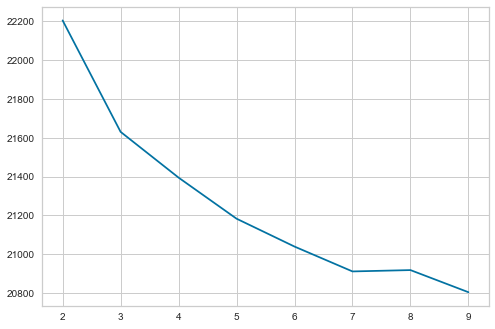

In [84]:
import matplotlib.pyplot as plt
_ = plt.plot(range(2,10), elbow)

The Elbow here can be found at at K=3.

### KMeans++

Let's compare the results obtained with an already implemented version from the scikit-learn library:

In [384]:
from sklearn.cluster import KMeans
kmeansSciKit = KMeans(n_clusters=4, random_state=42, init='k-means++', n_init=10, max_iter=300).fit(dfFinal) #subsetta le colonne boi
kmeansSciKit.inertia_

37767.36161953524

In [386]:
kmeans[0][1] #the .inertia_ of our model build from scratch

17496.00396102968

For sure it is faster on our machine, as %timeit would show. The sum of squared distances of samples to their closest cluster center is oddly higher, since with KMeans++ is 37767.36, while with our implementation is 17496.00. Maybe fine-tuning k the result would differ.

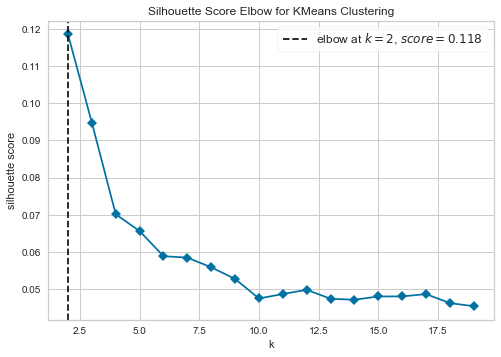

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [391]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,20), metric='silhouette', timings=False)
visualizer.fit(dfFinal)
visualizer.show()

## 2.4.1 Characterizing Clusters

We have chosen a bunch of variables that we think are relevant for identifying the genre of a song: 'track_duration', 'audio_features_acousticness', 'audio_features_danceability', 'audio_features_energy', 'audio_features_instrumentalness', 'audio_features_liveness', 'audio_features_speechiness', 'audio_features_tempo', 'audio_features_valence'. 

Some other variables, as 'metadata_artist_location', had far too many outliers and were dropped in the previous steps.

In [68]:
my_cols=['track_duration','audio_features_acousticness', 'audio_features_danceability', 'audio_features_energy', 'audio_features_instrumentalness', 'audio_features_liveness', 'audio_features_speechiness', 'audio_features_tempo', 'audio_features_valence']
dfNumStand[my_cols].describe()

,track_duration,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence
count,8493.000000,8493.000000,8493.000000,8493.000000,8493.000000,8493.000000,8493.000000,8493.000000,8493.000000
mean,0.076800,0.520256,0.470224,0.549522,0.637500,0.168547,0.079751,0.466035,0.438651
std,0.070566,0.382819,0.206633,0.274050,0.360360,0.163428,0.144258,0.146081,0.275370
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.045500,0.100586,0.316177,0.342588,0.321944,0.080907,0.015004,0.351407,0.196726
50%,0.064763,0.566678,0.465492,0.561924,0.833212,0.098446,0.027179,0.452549,0.416870
75%,0.087679,0.914901,0.622741,0.784331,0.916147,0.189480,0.065313,0.560916,0.660689
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 2.4.2 Categorize Numerical Variables

Let's categorize the variables, since they are all numerical:

In [69]:
dfCat = dfNumStand[my_cols].copy()

In [70]:
for col in list(dfCat.columns):
    dfCat[col] = pd.cut(df[col], 4, labels=[0,1,2,3])

In [71]:
dfCat

,track_duration,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence
0,0,1,2,2,0,0,0,2,2
1,0,1,2,3,0,0,1,1,1
2,0,0,3,2,0,1,0,1,2
3,0,1,2,2,0,0,2,1,3
4,0,0,0,2,3,0,0,3,0
...,...,...,...,...,...,...,...,...,...
8488,0,0,2,2,2,1,0,1,0
8489,0,0,2,2,1,0,0,1,1
8490,0,0,2,3,2,2,0,2,1
8491,0,0,2,3,1,0,0,1,1


### 2.4.3 - 2.4.4 Pivot tables

In [104]:
from sklearn.cluster import KMeans
kmeansSciKit = KMeans(n_clusters=4, random_state=42, init='k-means++', n_init=10, max_iter=300).fit(np.array(dfCat))

In [105]:
kmeansSciKit.labels_

array([0, 0, 0, ..., 1, 0, 0])

In [106]:
dfCat["clust"] = kmeansSciKit.labels_

In [112]:
from tabulate import tabulate

In [177]:
for ww in list(dfCat.columns)[:-1]:
    table=[]
    for x in range(4): #the number of levels of each category
        dfView = dfCat[[ww, "clust"]][dfCat[ww]==x]
        l=dfView.groupby("clust").agg('count')[ww]
        indx =list(dfView.groupby("clust").agg('count')[ww].index)
        ll=[0,0,0,0]
        for y in indx:
            ll[y]=l[y]
        table.append([round(j,2) for j in list(np.array(ll)/sum(list(ll)))])   
    aa = np.transpose(np.array(table)).tolist()
    aa.insert(0, ["Cluster 1","Cluster 2","Cluster 3","Cluster 4"])
    print(ww)
    print(tabulate(aa))

track_duration
---------  ---------  ---------  ---------
Cluster 1  Cluster 2  Cluster 3  Cluster 4
0.16       0.02       0.0        0.0
0.34       0.22       0.17       0.17
0.37       0.64       0.6        0.48
0.14       0.11       0.23       0.35
---------  ---------  ---------  ---------
audio_features_acousticness
---------  ---------  ---------  ---------
Cluster 1  Cluster 2  Cluster 3  Cluster 4
0.32       0.29       0.06       0.0
0.68       0.64       0.16       0.0
0.0        0.05       0.54       0.74
0.0        0.01       0.23       0.26
---------  ---------  ---------  ---------
audio_features_danceability
---------  ---------  ---------  ---------
Cluster 1  Cluster 2  Cluster 3  Cluster 4
0.11       0.15       0.17       0.19
0.28       0.26       0.37       0.56
0.53       0.44       0.29       0.15
0.08       0.15       0.17       0.1
---------  ---------  ---------  ---------
audio_features_energy
---------  ---------  ---------  ---------
Cluster 1  Cluster 2  Clu

### 2.4.5 Interpret Results

The indexes of each of the table above represents each one of the four category levels of the numberical variables.

'track_duration': poorly balanced, some cluster (3, 4) do not contain the first bin of the variable containing the smaller values, whereas other end up containing more than 60%

'audio_features_acousticness': poorly balanced, 3 clusters out of 4 do not contain some levels of the categorical variable, e.g. the fourth and first cluster contains 2 bins out of 4.

'audio_features_danceability': more balanced than the previous ones, still there are some cluster containing 8% of on level and more than 50% of another like the first one.

'audio_features_energy': more balanced again because all the cluster contain some portions of each variable, still in very different proportions (cluster 1 has 1% of a level and 62% of another one).

'audio_features_instrumentalness': poorly balanced, each cluster contains just two levels out of four.

'audio_features_liveness': Very balanced, the best one so far probably, since each cluster contains at least 10% of each level.



'audio_features_speechiness': Unbalanced, e.g., the 4th cluster contain 70% of one level of each level, and less than 10% for two others.

'audio_features_tempo': Slightly unbalanced, at least cluster 1 that contains more than 50% for the third level and less than 10% for the first.

'audio_features_valence': Slightly unbalanced, at least cluster 1 that contains more than 50% for the third level and less than 10% for the first.



### 2.4.6 Genre Comparison

To understand which is the most representative genre for each clusters we are going to repeat the previous step using teh genre variable. Looking back at the three initial datasets we can see that df3 has the following columns:

In [186]:
df3[[x for x in list(df3.columns) if "genre" in x]]

,track_genre_top,track_genres,track_genres_all
0,Hip-Hop,[21],[21]
1,Hip-Hop,[21],[21]
2,Hip-Hop,[21],[21]
3,Pop,[10],[10]
4,NaN,"[76, 103]","[17, 10, 76, 103]"
...,...,...,...
106569,Rock,[25],"[25, 12]"
106570,Rock,[25],"[25, 12]"
106571,Rock,[25],"[25, 12]"
106572,Rock,[25],"[25, 12]"


We are going to select column 'track_genre_top', that must be reinserted in the 'df' since it was dropped due to having too many NaN values. 

In [203]:
df=df1.merge(df2.merge(df3))["track_genre_top"]

In [202]:
df

0        Hip-Hop
1        Hip-Hop
2        Hip-Hop
3            Pop
4        Hip-Hop
          ...   
13097    Hip-Hop
13098    Hip-Hop
13099    Hip-Hop
13100    Hip-Hop
13101    Hip-Hop
Name: track_genre_top, Length: 9355, dtype: object

Since we have dropped 'track_genre_top' before we have to rebuild our dataset:

In [246]:
#Merge DataFrames
df=df1.merge(df2.merge(df3))
len(df.columns)

820

In [247]:
#Let's fill NAs with the value with the highest frequency, that is the first of this column:
temp=df['track_genre_top'].value_counts().reset_index()
temp

,index,track_genre_top
0,Rock,3892
1,Electronic,2170
2,Hip-Hop,910
3,Folk,874
4,Old-Time / Historic,357
5,Pop,346
6,Classical,265
7,Jazz,241
8,International,133
9,Instrumental,84


In [248]:
highestVal = temp["index"][0]
df['track_genre_top'].fillna(highestVal, inplace=True)
df['track_genre_top']

0        Hip-Hop
1        Hip-Hop
2        Hip-Hop
3            Pop
4        Hip-Hop
          ...   
13124       Rock
13125       Rock
13126       Rock
13127       Rock
13128       Rock
Name: track_genre_top, Length: 13129, dtype: object

In [249]:
threshold=0.25 #amount of NaNs that makes us drop that specific column
df.drop(columns=[x for x in df.columns if df[x].isnull().sum()/len(df.track_id) >=threshold], inplace=True)
print("{} columns have been dropped".format(820-len(list(df.columns))))

#Numerical Variables Handling
print(df.select_dtypes(include="number").shape)
for col in df.select_dtypes(include="number").columns:
    if  df[col].isnull().sum()!=0:
        df[col].fillna(df[col].describe()["50%"]) #substitute the median

#Categorical Variables Handling
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.drop(columns=["index"], inplace=True)

29 columns have been dropped
(13129, 771)


In [250]:
dfNum=df.select_dtypes(include="number")
dfNumStand = (dfNum - dfNum.min())/(dfNum.max()- dfNum.min())
dfNumStand

dfPca = dfNumStand.drop(columns=['track_id', 'album_comments', 'album_favorites', 'album_id', 'album_listens', 'album_tracks', 'artist_comments', 'artist_favorites', 'artist_id', 'track_comments', 'track_duration', 'track_favorites', 'track_interest', 'track_listens', 'track_number'])
dfPca

#there is a column with all NaN, probably a result of MinMax, maybe it had all equal values, let's drop it
df.drop([x for x in range(len(list(dfPca.isnull().sum()))) if list(dfPca.isnull().sum())[x]==8493])


df['chroma_stft_max_10'] #all 1.0 as values

dfPca.drop(columns=[list(dfPca.columns)[426]], inplace=True)

In [257]:
dfCat["genre"] = df['track_genre_top']

In [262]:
dfGenre = dfCat[["genre","clust"]].copy()
dfGenre

,genre,clust
0,Hip-Hop,0
1,Hip-Hop,0
2,Hip-Hop,0
3,Hip-Hop,0
4,Folk,1
...,...,...
8488,Rock,1
8489,Rock,0
8490,Rock,1
8491,Rock,0


In [343]:
#Number of components per cluster
print(dfGenre.groupby("clust").agg("count")["genre"])
freqClusters = list(dfGenre.groupby("clust").agg("count")["genre"])
freqClusters

clust
0    1322
1    2836
2    3162
3    1173
Name: genre, dtype: int64


[1322, 2836, 3162, 1173]

In [278]:
set(list(dfGenre.genre))

{'Blues',
 'Classical',
 'Electronic',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Jazz',
 'Old-Time / Historic',
 'Pop',
 'Rock'}

In [353]:
table=[]
for x in set(list(dfGenre.genre)): #the number of levels of each category
    dfView = dfGenre[dfGenre["genre"]==x]
    l=dfView.groupby("clust").agg('count')["genre"]
    indx =list(dfView.groupby("clust").agg('count')["genre"].index)
    ll=list(np.repeat(0,4))
    for y in indx:
        ll[y]=round(l[y]/freqClusters[y]*100,2)
    table.append(ll)

table.insert(0, ["Cluster 1","Cluster 2","Cluster 3","Cluster 4"])
print(tabulate(table))

---------  ---------  ---------  ---------
Cluster 1  Cluster 2  Cluster 3  Cluster 4
0.38       0.53       4.08       1.28
15.73      5.08       1.93       13.04
0          0.21       1.68       2.81
5.07       1.87       1.49       3.67
0          0          0.22       0.26
9.68       27.33      9.61       5.03
66.41      63.47      63.09      55.24
0          0          3.42       3.24
1.82       1.02       12.43      12.62
0.08       0.07       0.89       2.05
0.83       0.42       1.17       0.77
---------  ---------  ---------  ---------


### 2.4.7 Analyze first two datasets

In [392]:
df = df2.merge(df3)

In [493]:
threshold=0.25 #amount of NaNs that makes us drop that specific column
df.drop(columns=[x for x in df.columns if df[x].isnull().sum()/len(df.track_id) >=threshold], inplace=True)
#Numerical Variables Handling
for col in df.select_dtypes(include="number").columns:
    if  df[col].isnull().sum()!=0:
        df[col].fillna(df[col].describe()["50%"]) #substitute the median
#Categorical Variables Handling
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.drop(columns=["index"], inplace=True)
dfNum=df.select_dtypes(include="number")
dfNumStand = (dfNum - dfNum.min())/(dfNum.max()- dfNum.min())
dfNumStand
dfPca = dfNumStand.drop(columns=['track_id', 'album_comments', 'album_favorites', 'album_id', 'album_listens', 'album_tracks', 'artist_comments', 'artist_favorites', 'artist_id', 'track_comments', 'track_duration', 'track_favorites', 'track_interest', 'track_listens', 'track_number'])
dfPca

,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,...,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01,track_bit_rate
0,0.001033,0.002501,0.001246,0.001021,0.001067,0.001518,0.000798,0.001470,0.003169,0.002444,...,0.130829,0.101443,0.000915,0.454097,0.097468,0.079564,0.000000,0.194863,0.142931,0.571430
1,0.000435,0.000941,0.001300,0.001243,0.001121,0.001231,0.000771,0.001047,0.002547,0.002038,...,0.152235,0.150073,0.000568,0.461007,0.096271,0.071390,0.000000,0.190782,0.161548,0.571430
2,0.000281,0.000649,0.000948,0.000865,0.001210,0.001734,0.000236,0.000535,0.003005,0.002274,...,0.135841,0.124322,0.001040,0.368707,0.060433,0.046322,0.000000,0.195994,0.103753,0.571430
3,0.000199,0.000606,0.001219,0.000765,0.000845,0.001242,0.000384,0.000564,0.002495,0.001236,...,0.241482,0.181304,0.002208,0.464462,0.053726,0.044687,0.004175,0.206892,0.070999,0.571430
4,0.000142,0.000437,0.001133,0.000714,0.000346,0.000622,0.000241,0.000757,0.002220,0.001204,...,0.274343,0.202822,0.005167,0.242843,0.020880,0.017439,0.000000,0.223305,0.032276,0.571430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81255,0.000185,0.000904,0.001836,0.000562,0.000255,0.000567,0.000466,0.000897,0.001757,0.001394,...,0.178303,0.123851,0.001056,0.180158,0.042886,0.039237,0.012526,0.191301,0.041914,0.714286
81256,0.000166,0.000838,0.002410,0.000684,0.001124,0.002498,0.000396,0.002245,0.003139,0.002788,...,0.242072,0.168007,0.000760,0.164363,0.032709,0.031608,0.016701,0.182455,0.027047,0.714286
81257,0.000169,0.000596,0.000826,0.000605,0.000643,0.001026,0.000305,0.000753,0.002271,0.001412,...,0.252855,0.225978,0.000621,0.188055,0.035378,0.031063,0.010438,0.186039,0.042812,0.714286
81258,0.000284,0.000637,0.000807,0.000766,0.000532,0.000861,0.000852,0.001141,0.003545,0.001757,...,0.188107,0.173668,0.000512,0.204837,0.043731,0.041417,0.014614,0.181069,0.040084,0.714286


In [394]:
threshold=0.25 #amount of NaNs that makes us drop that specific column
df.drop(columns=[x for x in df.columns if df[x].isnull().sum()/len(df.track_id) >=threshold], inplace=True)
#Numerical Variables Handling
for col in df.select_dtypes(include="number").columns:
    if  df[col].isnull().sum()!=0:
        df[col].fillna(df[col].describe()["50%"]) #substitute the median
#Categorical Variables Handling
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.drop(columns=["index"], inplace=True)
dfNum=df.select_dtypes(include="number")
dfNumStand = (dfNum - dfNum.min())/(dfNum.max()- dfNum.min())
dfNumStand
dfPca = dfNumStand.drop(columns=['track_id', 'album_comments', 'album_favorites', 'album_id', 'album_listens', 'album_tracks', 'artist_comments', 'artist_favorites', 'artist_id', 'track_comments', 'track_duration', 'track_favorites', 'track_interest', 'track_listens', 'track_number'])
dfPca
#there is a column with all NaN, probably a result of MinMax, maybe it had all equal values, let's drop it
df.drop([x for x in range(len(list(dfPca.isnull().sum()))) if list(dfPca.isnull().sum())[x]==8493])
dfPca.drop(columns=[list(dfPca.columns)[426]], inplace=True)
from sklearn.decomposition import PCA
import random
random.seed(42)
pca = PCA(n_components=0.71) 
pca_fit = pca.fit_transform(dfPca)
pca_reduced=pca.transform(dfPca)
pca_reduced=pd.DataFrame(pca_reduced)
pca_reduced["track_id"] = dfNumStand["track_id"]
pca_reduced
dfFinal = pca_reduced.merge(dfNumStand[['track_id', 'album_comments', 'album_favorites', 'album_id', 'album_listens', 'album_tracks', 'artist_comments', 'artist_favorites', 'artist_id', 'track_comments', 'track_duration', 'track_favorites', 'track_interest', 'track_listens', 'track_number']])

In [395]:
dfFinal

,0,1,2,3,4,5,6,7,8,9,...,album_tracks,artist_comments,artist_favorites,artist_id,track_comments,track_duration,track_favorites,track_interest,track_listens,track_number
0,0.375040,0.206308,-0.523815,-0.560306,0.681392,-0.542461,0.139373,-0.228029,0.216941,-0.038427,...,0.017995,0.000000,0.009346,0.000000,0.0,0.015251,0.001350,0.001413,0.002378,0.011765
1,0.625144,-0.114948,-0.706591,0.402851,-0.022939,-0.082945,0.514290,-0.004243,-0.092047,0.175757,...,0.017995,0.000000,0.009346,0.000000,0.0,0.021514,0.000675,0.000445,0.000944,0.015686
2,0.272829,0.145597,-0.503473,0.092829,0.241075,0.111437,0.150853,-0.069710,0.187075,-0.150470,...,0.017995,0.000000,0.009346,0.000000,0.0,0.018700,0.004049,0.000586,0.002117,0.023529
3,-0.051040,-0.224888,0.064600,0.506474,0.096886,0.184337,0.006268,-0.243067,-0.357787,-0.270660,...,0.033419,0.025316,0.010384,0.000123,0.0,0.028232,0.000000,0.000296,0.000663,0.011765
4,-0.279286,-0.297648,0.157508,0.210684,-0.160547,-0.075879,-0.272167,0.312805,-0.001237,-0.150691,...,0.033419,0.025316,0.010384,0.000123,0.0,0.016431,0.000000,0.000321,0.000353,0.015686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81255,0.042104,-0.118114,0.327994,0.089566,-0.431162,0.064917,-0.367345,-0.157894,-0.068857,0.048965,...,0.015424,0.000000,0.000000,1.000000,0.0,0.003450,0.000675,0.000046,0.000234,0.003922
81256,0.211228,-0.006202,0.899888,-0.385313,-0.723334,-0.089472,-0.610256,-0.172774,0.004979,0.215597,...,0.015424,0.000000,0.000000,1.000000,0.0,0.014706,0.000675,0.000036,0.000186,0.011765
81257,0.270704,-0.509796,0.693941,0.036166,0.193103,0.762566,-0.396723,0.076368,-0.391246,-0.044614,...,0.015424,0.000000,0.000000,1.000000,0.0,0.019699,0.000675,0.000058,0.000302,0.015686
81258,0.575773,-0.220710,0.335056,-0.194526,-0.430708,0.025460,-0.416892,0.035725,-0.286470,0.138642,...,0.015424,0.000000,0.000000,1.000000,0.0,0.036674,0.001350,0.000064,0.000307,0.023529


In [396]:
from sklearn.cluster import KMeans
kmeansSciKit = KMeans(n_clusters=4, random_state=42, init='k-means++', n_init=10, max_iter=300).fit(dfFinal)

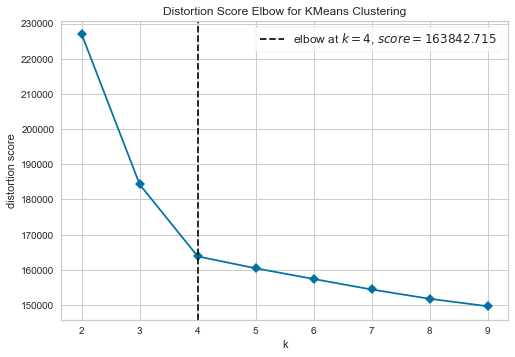

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [462]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion', timings=False)
visualizer.fit(dfFinal)
visualizer.show()

In [418]:
dfAdilet = dfFinal.drop(columns=[x for x in list(dfFinal.columns) if isinstance(x, int)]).copy()
dfAdilet

,track_id,album_comments,album_favorites,album_id,album_listens,album_tracks,artist_comments,artist_favorites,artist_id,track_comments,track_duration,track_favorites,track_interest,track_listens,track_number,clust
0,0.000000,0.0,0.065574,0.000000,0.001699,0.017995,0.000000,0.009346,0.000000,0.0,0.015251,0.001350,0.001413,0.002378,0.011765,0
1,0.000006,0.0,0.065574,0.000000,0.001699,0.017995,0.000000,0.009346,0.000000,0.0,0.021514,0.000675,0.000445,0.000944,0.015686,0
2,0.000019,0.0,0.065574,0.000000,0.001699,0.017995,0.000000,0.009346,0.000000,0.0,0.018700,0.004049,0.000586,0.002117,0.023529,0
3,0.000116,0.0,0.032787,0.000131,0.000756,0.033419,0.025316,0.010384,0.000123,0.0,0.028232,0.000000,0.000296,0.000663,0.011765,0
4,0.000155,0.0,0.032787,0.000131,0.000756,0.033419,0.025316,0.010384,0.000123,0.0,0.016431,0.000000,0.000321,0.000353,0.015686,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81255,0.999974,0.0,0.000000,1.000000,0.000418,0.015424,0.000000,0.000000,1.000000,0.0,0.003450,0.000675,0.000046,0.000234,0.003922,1
81256,0.999981,0.0,0.000000,1.000000,0.000418,0.015424,0.000000,0.000000,1.000000,0.0,0.014706,0.000675,0.000036,0.000186,0.011765,1
81257,0.999987,0.0,0.000000,1.000000,0.000418,0.015424,0.000000,0.000000,1.000000,0.0,0.019699,0.000675,0.000058,0.000302,0.015686,1
81258,0.999994,0.0,0.000000,1.000000,0.000418,0.015424,0.000000,0.000000,1.000000,0.0,0.036674,0.001350,0.000064,0.000307,0.023529,1


In [425]:
for col in list(dfAdilet.columns):
    dfAdilet[col] = pd.cut(dfAdilet[col], 4, labels=[0,1,2,3])

In [426]:
dfAdilet

,track_id,album_comments,album_favorites,album_id,album_listens,album_tracks,artist_comments,artist_favorites,artist_id,track_comments,track_duration,track_favorites,track_interest,track_listens,track_number,clust
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81255,3,0,0,3,0,0,0,0,3,0,0,0,0,0,0,1
81256,3,0,0,3,0,0,0,0,3,0,0,0,0,0,0,1
81257,3,0,0,3,0,0,0,0,3,0,0,0,0,0,0,1
81258,3,0,0,3,0,0,0,0,3,0,0,0,0,0,0,1


In [436]:
print(dfAdilet.groupby("clust").agg("count")["track_id"])
freqClusters = list(dfAdilet.groupby("clust").agg("count")["track_id"])
freqClusters

clust
0    21708
1    21779
2    19342
3    18431
Name: track_id, dtype: int64


[21708, 21779, 19342, 18431]

In [502]:
from tabulate import tabulate
my_cols=[]
for ww in list(dfAdilet.drop(columns=["track_id","album_id","artist_id",]).columns)[:5]:
    freqClusters = list(dfAdilet.groupby("clust").agg("count")[ww])
    #print(freqClusters)
    table=[]
    for x in range(4): #the number of levels of each category
        dfView = dfAdilet[[ww, "clust"]][dfAdilet[ww]==x]  
        l=dfView.groupby("clust").agg('count')[ww]
        #print(list(l))
        indx =list(dfView.groupby("clust").agg('count')[ww].index)
        ll=[0,0,0,0]
        for y in indx:
            ll[y]=round(l[y]/freqClusters[y]*100,2)
        table.append(ll)
    aa = np.array(table).tolist()
    aa.insert(0, ["Cluster 1","Cluster 2","Cluster 3","Cluster 4"])
    print(ww)
    print(tabulate(aa))

album_comments
---------  ---------  ---------  ---------
Cluster 1  Cluster 2  Cluster 3  Cluster 4
99.74      99.89      99.44      99.88
0.18       0.06       0.05       0.05
0.0        0.0        0.0        0.0
0.08       0.05       0.51       0.07
---------  ---------  ---------  ---------
album_favorites
---------  ---------  ---------  ---------
Cluster 1  Cluster 2  Cluster 3  Cluster 4
99.49      99.38      98.3       99.7
0.45       0.45       1.29       0.16
0.05       0.11       0.25       0.05
0.0        0.06       0.15       0.08
---------  ---------  ---------  ---------
album_listens
---------  ---------  ---------  ---------
Cluster 1  Cluster 2  Cluster 3  Cluster 4
99.87      99.82      99.03      99.84
0.05       0.13       0.47       0.1
0.0        0.0        0.0        0.0
0.08       0.05       0.51       0.07
---------  ---------  ---------  ---------
album_tracks
---------  ---------  ---------  ---------
Cluster 1  Cluster 2  Cluster 3  Cluster 4
97.88      95.

We have totally different variables, since the one picked before were in the echonest dataframe, thus we can't really make a comparison.

# 3 Algorithmic Question

You are given a list of integers, A, and another integer s. Write an algorithm that outputs all the pairs in A that equal x.

E.g., A = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] and s = 4

The algorithm should output: (7, -3), (-2, 6), (2, 2), (3, 1).

Since there is no strict requirement on the running time, an $O(n^2)$ solution would be the easiest to code. Here it follows:

In [24]:
A, s = [7, -2,  8, 2, 6, 4, -7, 2, 1, 3, -3], 4 
out=[]
for i in range(len(A)):
    for j in range(len(A)):
        if i!=j and A[i]+A[j]==s and sorted((A[i],A[j])) not in out:
            out.append(sorted((A[i],A[j])))

In [25]:
out

[[-3, 7], [-2, 6], [2, 2], [1, 3]]

In [ ]:
#Why would you need more than 1 line?
[list(x) if len(list(x))==2 else list(x)+list(x) for x in list(set([frozenset([A[x],A[y]]) for y in range(len(A)) for x in range(len(A)) if (A[x]+A[y] ==s and x!=y)]))]

However, in this way do not take all the pairs into account, namely elements that appear multiple times in A and belong to a pair in "out" would appear just once in "out".

E.g., A=[1,1,2], s=3 --> out=[(1,2)], even if we could consider 1 and 1 as different elements.

To overcome this, if we feel the need to, we can keep track of indexes in the following way:

In [27]:
A, s = [1, 1, 2], 3 
out=[]
out_idx=[]
for i in range(len(A)):
    for j in range(len(A)):
        if i!=j and A[i]+A[j]==s:
            if sorted((A[i],A[j])) not in out:
                out.append(sorted((A[i],A[j])))
                out_idx.append(sorted((i,j)))
            elif sorted((i,j)) not in out_idx:
                out.append(sorted((A[i],A[j])))
                out_idx.append(sorted((i,j)))

In [28]:
print(out, out_idx)

[[1, 2], [1, 2]] [[0, 2], [1, 2]]


### Other possible implementations

Sorting the array, $O(nlogn$) using e.g. Mergesort, iterating over it, $O(n)$, and applying Binary Search, $O(logn)$, to check if (s - i-th element) is in the array is another possibility. Overall, it would cost $O(nlogn) + O(n)*O(logn) = O(nlogn + n*logn) =O(nlogn)$